In [144]:
!pip install statsmodels


In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from google.colab import files

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
np.random.seed(42)


In [146]:
n = 2000
dates = pd.date_range(start="2022-01-01", periods=n, freq="D")

trend = np.linspace(0, 40, n)
weekly = 10 * np.sin(2 * np.pi * np.arange(n) / 7)

cpu = 50 + trend * 0.2 + weekly + np.random.normal(0, 2, n)
memory = 65 + trend * 0.15 + weekly * 0.8 + np.random.normal(0, 1.5, n)
usage_qty = 120 + trend * 2 + weekly * 3 + np.random.normal(0, 8, n)
cost = 1500 + usage_qty * 6 + cpu * 8 + np.random.normal(0, 40, n)

df = pd.DataFrame({
    "Usage Start Date": dates,
    "CPU Utilization (%)": cpu,
    "Memory Utilization (%)": memory,
    "Usage Quantity": usage_qty,
    "Total Cost (INR)": cost
})

df.set_index("Usage Start Date", inplace=True)

df.head()


,CPU Utilization (%),Memory Utilization (%),Usage Quantity,Total Cost (INR)
Usage Start Date,,,,
2022-01-01,50.993428,63.987233,113.092051,2541.936479
2022-01-02,57.545788,71.040875,143.245337,2794.601092
2022-01-03,61.052660,71.616796,149.472012,2847.570948
2022-01-04,57.396903,68.018132,136.917615,2758.761082
2022-01-05,45.208864,58.700514,96.208701,2430.357104


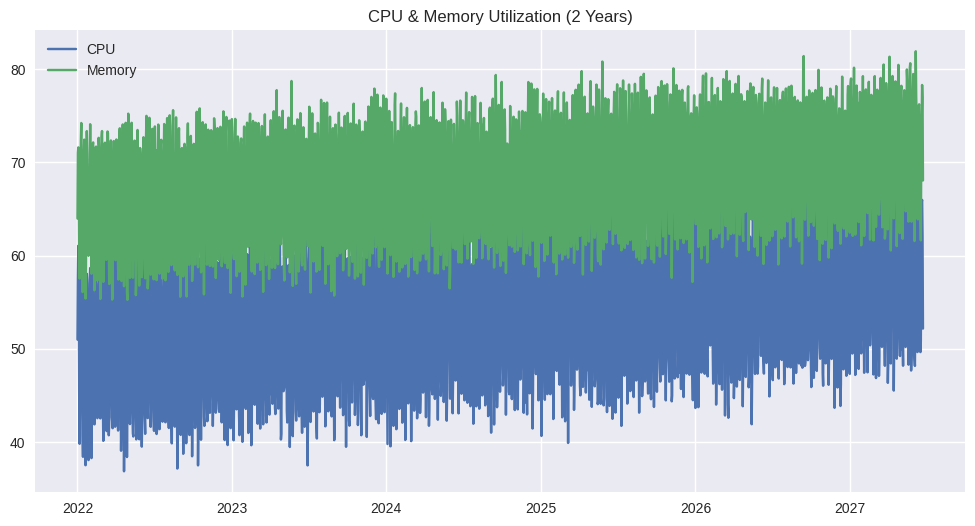

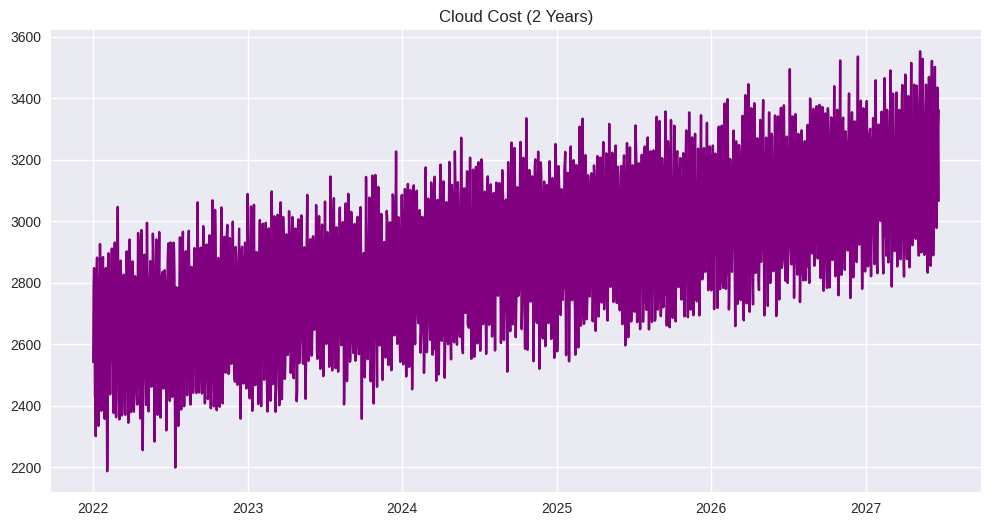

In [147]:
plt.figure(figsize=(12,6))
plt.plot(df["CPU Utilization (%)"], label="CPU")
plt.plot(df["Memory Utilization (%)"], label="Memory")
plt.legend()
plt.title("CPU & Memory Utilization (2 Years)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(df["Total Cost (INR)"], color="purple")
plt.title("Cloud Cost (2 Years)")
plt.grid(True)
plt.show()


In [148]:
def split(series):
    split_point = int(len(series) * 0.8)
    return series[:split_point], series[split_point:]


In [149]:
def evaluate(series, name):

    train, test = split(series)

    # ARIMA
    arima = ARIMA(train, order=(2,1,2)).fit()
    arima_train_pred = arima.predict(start=train.index[0],
                                     end=train.index[-1],
                                     typ='levels')
    arima_test_pred = arima.forecast(steps=len(test))

    # SARIMA
    sarima = SARIMAX(train,
                     order=(2,1,2),
                     seasonal_order=(1,1,1,7)).fit(disp=False)
    sarima_train_pred = sarima.predict(start=train.index[0],
                                       end=train.index[-1],
                                       typ='levels')
    sarima_test_pred = sarima.forecast(steps=len(test))

    # Metrics
    results = {
        "Resource": name,

        "ARIMA_Train_R2": r2_score(train, arima_train_pred),
        "ARIMA_Test_R2": r2_score(test, arima_test_pred),

        "SARIMA_Train_R2": r2_score(train, sarima_train_pred),
        "SARIMA_Test_R2": r2_score(test, sarima_test_pred),

        "SARIMA_Test_RMSE": np.sqrt(mean_squared_error(test, sarima_test_pred)),
        "SARIMA_Test_MAE": mean_absolute_error(test, sarima_test_pred),
        "SARIMA_Test_MAPE": np.mean(np.abs((test - sarima_test_pred) / test)) * 100
    }

    print(f"\n{name} Performance")
    print("----------------------------------")
    print("ARIMA Test R2:", results["ARIMA_Test_R2"])
    print("SARIMA Test R2:", results["SARIMA_Test_R2"])
    print("RMSE:", results["SARIMA_Test_RMSE"])
    print("MAE:", results["SARIMA_Test_MAE"])
    print("MAPE:", results["SARIMA_Test_MAPE"])
    print("----------------------------------")

    # Forecast Graph
    plt.figure(figsize=(12,6))
    plt.plot(test.index, test, label="Actual")
    plt.plot(test.index, arima_test_pred, label="ARIMA")
    plt.plot(test.index, sarima_test_pred, label="SARIMA")
    plt.legend()
    plt.title(f"{name} Forecast Comparison")
    plt.grid(True)
    plt.show()

    # Scatter Plot
    plt.figure(figsize=(6,6))
    plt.scatter(test, sarima_test_pred)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} Actual vs Predicted")
    plt.grid(True)
    plt.show()

    # Residual Diagnostics
    residuals = test - sarima_test_pred

    plt.figure(figsize=(10,4))
    plt.plot(residuals)
    plt.title(f"{name} Residual Plot")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True)
    plt.title(f"{name} Residual Distribution")
    plt.show()

    plt.figure(figsize=(8,4))
    plot_acf(residuals, lags=30)
    plt.title(f"{name} Residual ACF")
    plt.show()

    return results



CPU Performance
----------------------------------
ARIMA Test R2: 0.05409409218843286
SARIMA Test R2: 0.9274844113440338
RMSE: 1.945095225031096
MAE: 1.5364763453960995
MAPE: 2.729556811669938
----------------------------------


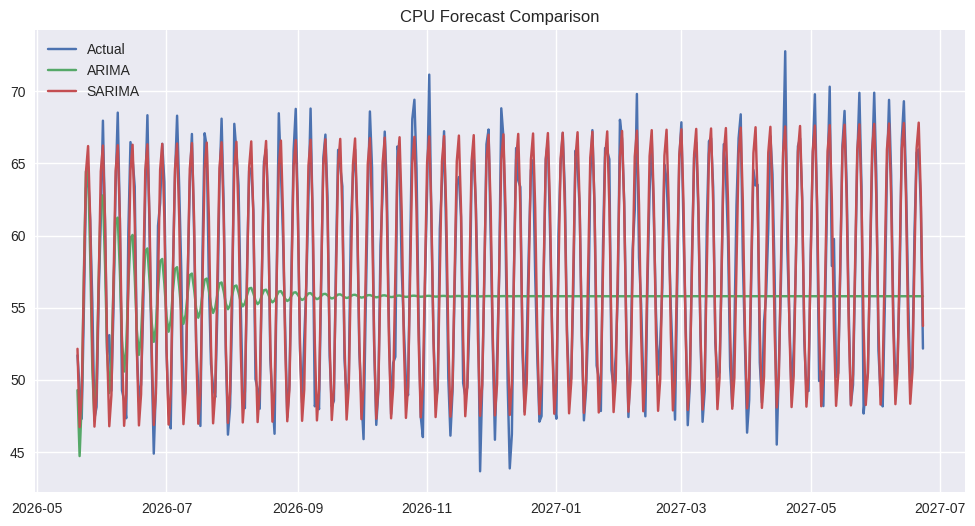

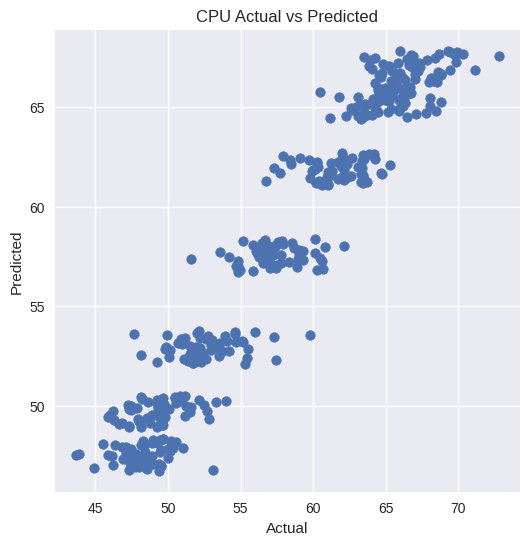

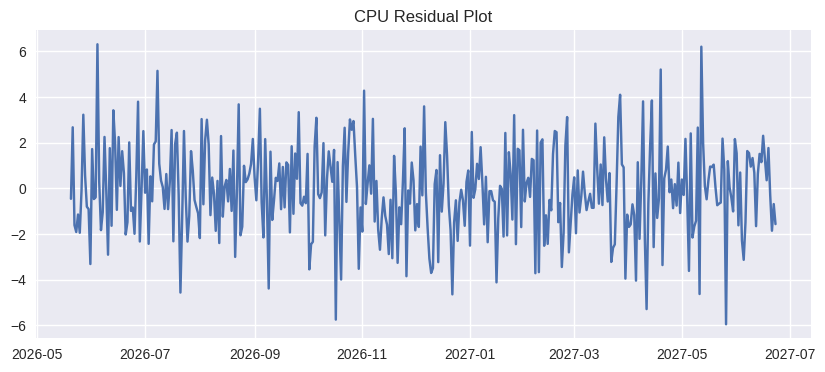

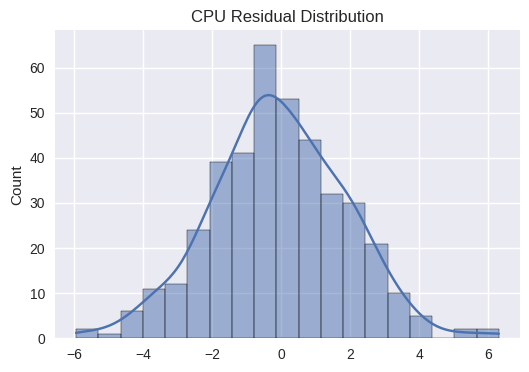

<Figure size 800x400 with 0 Axes>

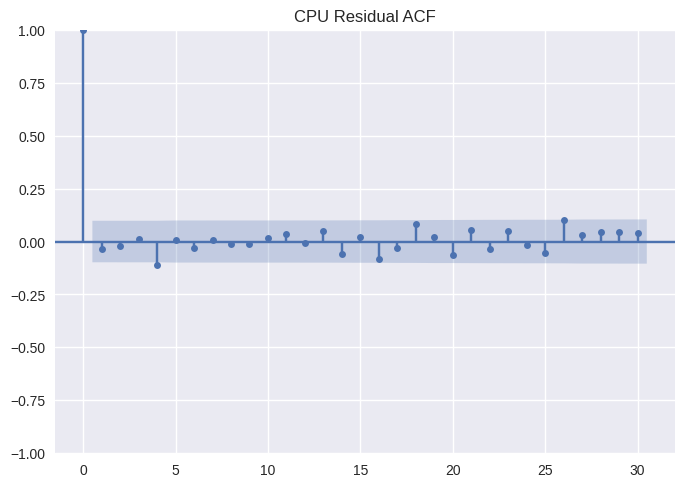


Memory Performance
----------------------------------
ARIMA Test R2: 0.11772002084226263
SARIMA Test R2: 0.9343552948057712
RMSE: 1.492465237665577
MAE: 1.189795172060665
MAPE: 1.7119571579900497
----------------------------------


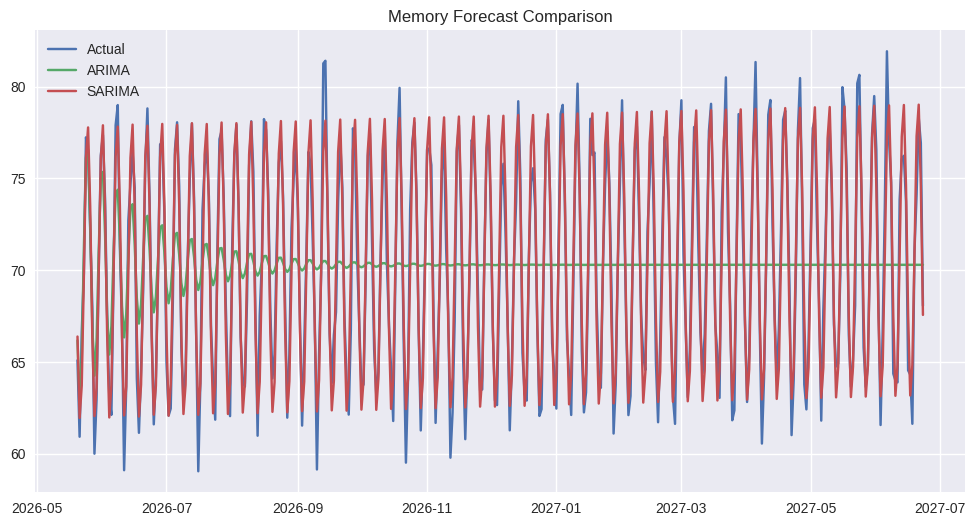

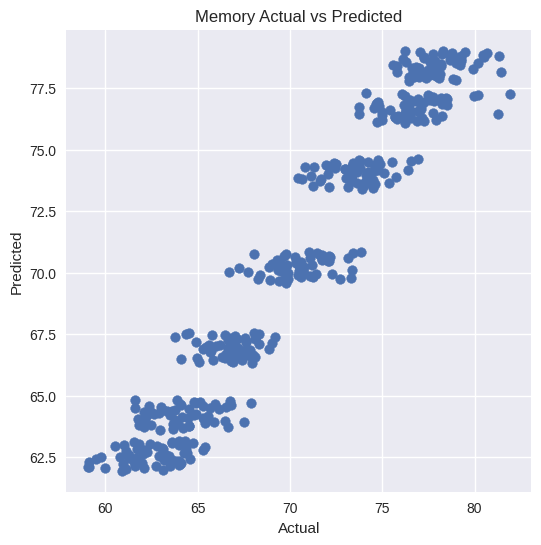

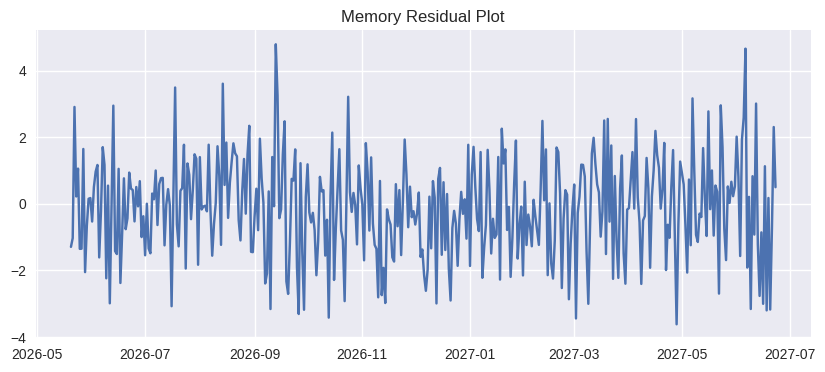

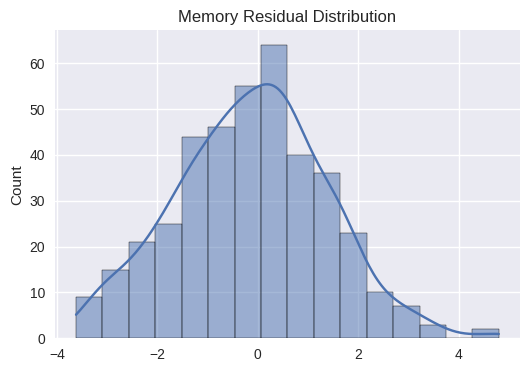

<Figure size 800x400 with 0 Axes>

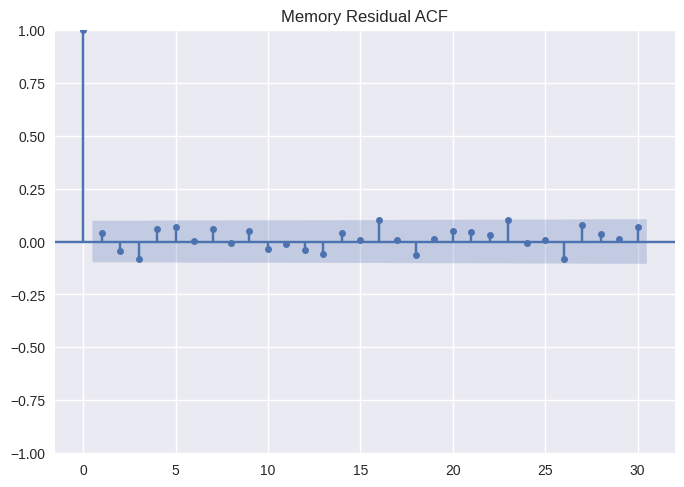


Cost Performance
----------------------------------
ARIMA Test R2: -0.051558506938027104
SARIMA Test R2: 0.8783653298742214
RMSE: 69.97641278782153
MAE: 55.65233054139002
MAPE: 1.7947930280260385
----------------------------------


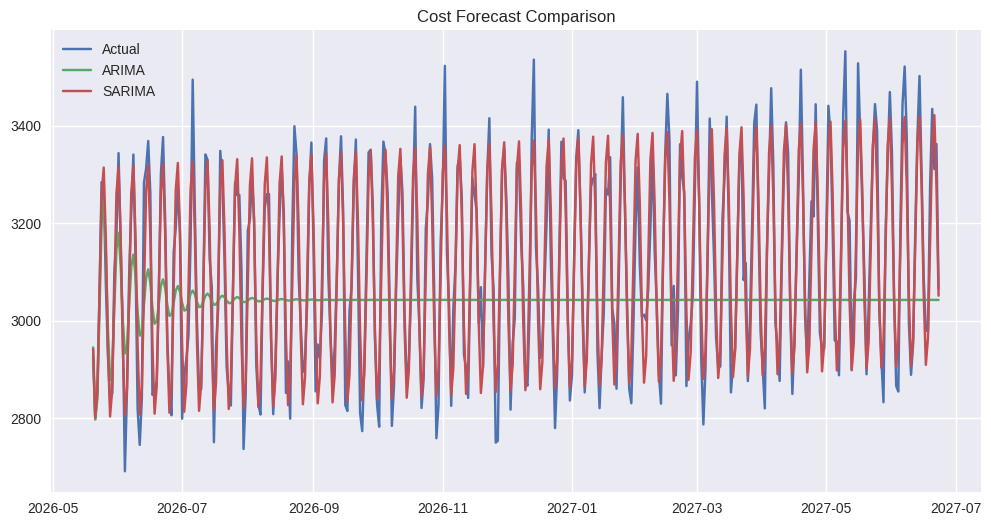

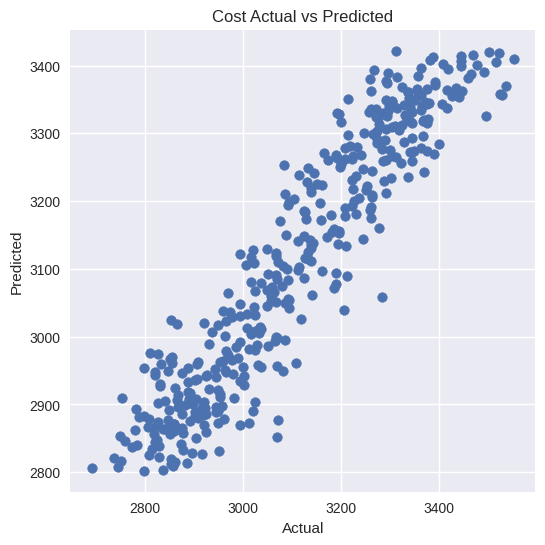

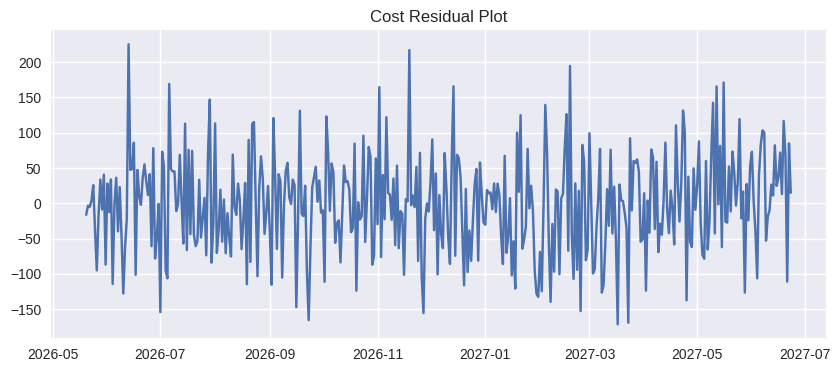

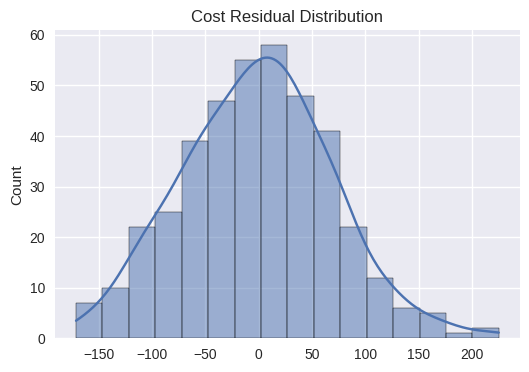

<Figure size 800x400 with 0 Axes>

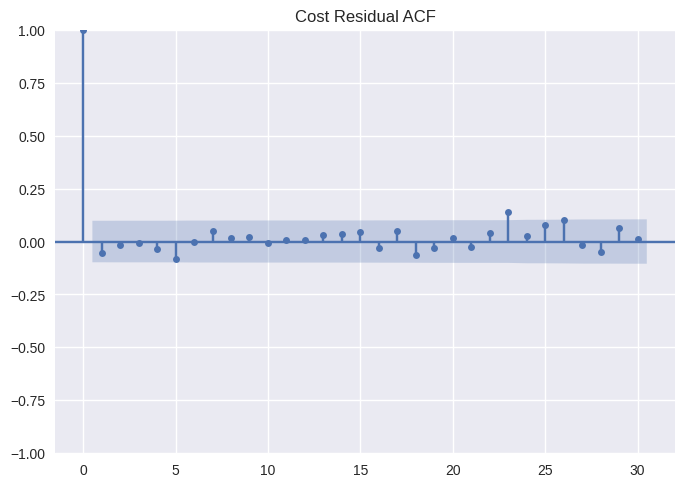

,Resource,ARIMA_Train_R2,ARIMA_Test_R2,SARIMA_Train_R2,SARIMA_Test_R2,SARIMA_Test_RMSE,SARIMA_Test_MAE,SARIMA_Test_MAPE
0,CPU,0.837550,0.054094,0.894179,0.927484,1.945095,1.536476,2.729557
1,Memory,0.808327,0.117720,0.851511,0.934355,1.492465,1.189795,1.711957
2,Cost,0.772759,-0.051559,0.829638,0.878365,69.976413,55.652331,1.794793


In [150]:
cpu_results = evaluate(df["CPU Utilization (%)"], "CPU")
memory_results = evaluate(df["Memory Utilization (%)"], "Memory")
cost_results = evaluate(df["Total Cost (INR)"], "Cost")

final_results = pd.DataFrame([cpu_results, memory_results, cost_results])
final_results


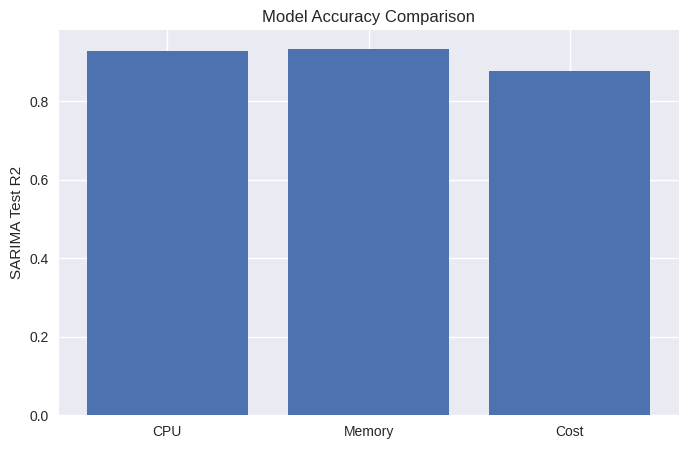

In [151]:
plt.figure(figsize=(8,5))
plt.bar(final_results["Resource"],
        final_results["SARIMA_Test_R2"])
plt.ylabel("SARIMA Test R2")
plt.title("Model Accuracy Comparison")
plt.grid(True)
plt.show()


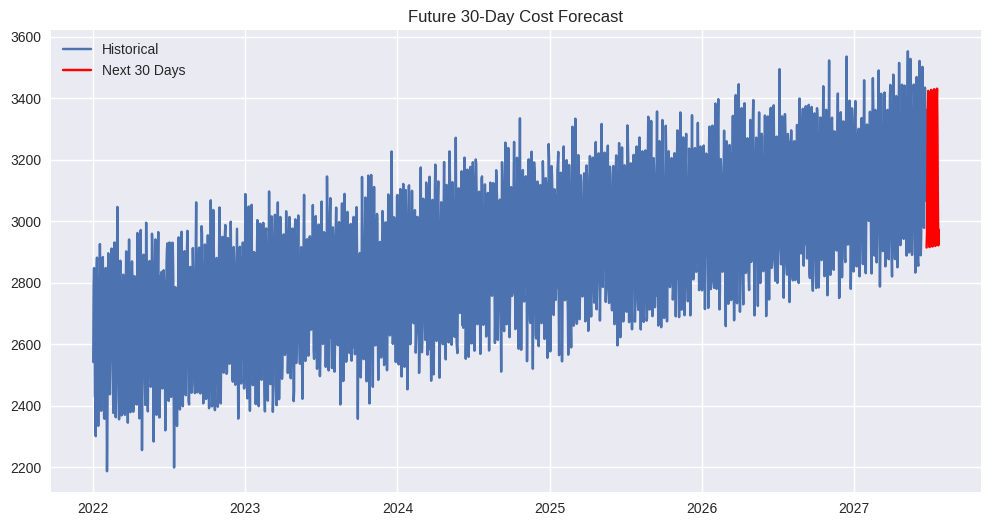

In [152]:
final_model = SARIMAX(df["Total Cost (INR)"],
                      order=(2,1,2),
                      seasonal_order=(1,1,1,7)).fit(disp=False)

future_forecast = final_model.forecast(steps=30)

plt.figure(figsize=(12,6))
plt.plot(df["Total Cost (INR)"], label="Historical")
plt.plot(future_forecast.index,
         future_forecast,
         color="red",
         label="Next 30 Days")
plt.legend()
plt.title("Future 30-Day Cost Forecast")
plt.grid(True)
plt.show()


In [153]:
# Save dataset
df.to_csv("cloud_dataset_2years.csv")

# Save evaluation results
final_results.to_csv("model_results.csv")

# Save future forecast
future_forecast.to_csv("future_30day_forecast.csv")

# Download files
files.download("cloud_dataset_2years.csv")
files.download("model_results.csv")
files.download("future_30day_forecast.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>